In [1]:
import sys, os
sys.path.insert(0, os.getcwd()+'/..')

import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
from PIL import Image
import caffe
from DataLoader import load_cifar
%matplotlib inline

caffe.set_mode_gpu()
caffe.set_device(0)

load_cifar(datapath = '../Data')
print 'ok'

ok


In [31]:
import caffe
from caffe import layers as L
from caffe import params as P


def cnn(hdf5, batch_size):
    n = caffe.NetSpec()
    n.data, n.label_coarse, n.label_fine = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=3)
    
    n.conv1 = L.Convolution(n.data, kernel_size=4, num_output=64, weight_filler=dict(type='xavier'))
    n.cccp1a = L.Convolution(n.conv1, kernel_size=1, num_output=42, weight_filler=dict(type='xavier'))
    n.relu1a = L.ReLU(n.cccp1a, in_place=True)
    n.cccp1b = L.Convolution(n.relu1a, kernel_size=1, num_output=32, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.cccp1b, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    n.drop1 = L.Dropout(n.pool1, in_place=True)
    n.relu1b = L.ReLU(n.drop1, in_place=True)
    
    n.conv2 = L.Convolution(n.relu1b, kernel_size=4, num_output=42, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    n.drop2 = L.Dropout(n.pool2, in_place=True)
    n.relu2 = L.ReLU(n.drop2, in_place=True)
    
    n.conv3 = L.Convolution(n.relu2, kernel_size=2, num_output=64, weight_filler=dict(type='xavier'))
    n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride=2, pool=P.Pooling.AVE)
    n.relu3 = L.ReLU(n.pool3, in_place=True)
    
    n.ip1 = L.InnerProduct(n.relu3, num_output=768, weight_filler=dict(type='xavier'))
    n.sig1 = L.Sigmoid(n.ip1, in_place=True)
    
    n.ip_c = L.InnerProduct(n.sig1, num_output=20, weight_filler=dict(type='xavier'))
    n.accuracy_c = L.Accuracy(n.ip_c, n.label_coarse)
    n.loss_c = L.SoftmaxWithLoss(n.ip_c, n.label_coarse)
    
    n.ip_f = L.InnerProduct(n.sig1, num_output=100, weight_filler=dict(type='xavier'))
    n.accuracy_f = L.Accuracy(n.ip_f, n.label_fine)
    n.loss_f = L.SoftmaxWithLoss(n.ip_f, n.label_fine)
    
    return n.to_proto()
    

def lenet(hdf5, batch_size):
    n = caffe.NetSpec()
    n.data, n.label_coarse, n.label_fine = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=3)
    
    
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=48, weight_filler=dict(type='xavier'))
    n.cccp1a = L.Convolution(n.conv1, kernel_size=1, num_output=42, weight_filler=dict(type='xavier'))
    n.relu1a = L.ReLU(n.cccp1a, in_place=True)
    n.cccp1b = L.Convolution(n.relu1a, kernel_size=1, num_output=32, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.relu1a, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.drop1 = L.Dropout(n.pool1, in_place=True)
    #n.relu1b = L.ReLU(n.drop1, in_place=True)
    
    n.conv2 = L.Convolution(n.drop1, kernel_size=4, num_output=42, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    #n.drop2 = L.Dropout(n.pool2, in_place=True)
    n.relu2 = L.ReLU(n.pool2, in_place=True)
    
    n.conv3 = L.Convolution(n.relu2, kernel_size=2, num_output=64, weight_filler=dict(type='xavier'))
    n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride=2, pool=P.Pooling.AVE)
    #n.relu3 = L.ReLU(n.pool3, in_place=True)
    
    n.ip1 = L.InnerProduct(n.pool3, num_output=350, weight_filler=dict(type='xavier'))
    n.sig1 = L.Sigmoid(n.ip1, in_place=True)
    
    #n.ip_c = L.InnerProduct(n.sig1, num_output=20, weight_filler=dict(type='xavier'))
    #n.accuracy_c = L.Accuracy(n.ip_c, n.label_coarse)
    #n.loss_c = L.SoftmaxWithLoss(n.ip_c, n.label_coarse)
    
    n.ip_f = L.InnerProduct(n.sig1, num_output=100, weight_filler=dict(type='xavier'))
    n.accuracy_f = L.Accuracy(n.ip_f, n.label_fine)
    n.loss_f = L.SoftmaxWithLoss(n.ip_f, n.label_fine)
    
    
    return n.to_proto()



import h5py
def balance_data(dataset = '../Data/cifar-100/train.h5', num_per_class = 100):
    h5 = h5py.File(dataset, 'r')
    data = h5['data'][:]
    labels = h5['label_fine'][:]
    coarse = h5['label_coarse'][:]
    sorted_labels = np.sort(labels)
    indices = np.argsort(labels)
    old_class = sorted_labels[0]
    counter=0
    idx=0
    new_data = np.zeros([100*num_per_class, 3, 32, 32], np.float64)
    new_labels = np.zeros(100*num_per_class, np.float64)
    new_coarse = np.zeros(100*num_per_class, np.float64)
    for i in range (1, np.size(labels)):
        current_class = sorted_labels[i]
        if (counter < num_per_class):
            new_data[idx,:, :, :] = data[indices[i], :, :, :]
            new_labels[idx] = labels[indices[i]]
            new_coarse[idx] = coarse[indices[i]]
            counter = counter + 1
            idx += 1
        if current_class != old_class:
            counter = 0
        old_class = current_class
    new_path = dataset+str(num_per_class)
    print new_path
    with h5py.File(new_path, 'w') as hf:
        hf.create_dataset('data', data=new_data)
        hf.create_dataset('label_fine', data=new_labels)
        hf.create_dataset('label_coarse', data=new_coarse)

def feed_data(num_per_class):
    with open('cnn_train.prototxt', 'w') as f:
        f.write(str(cnn('train{}.txt'.format(num_per_class), 128)))
    
    with open('cnn_test.prototxt', 'w') as f:
        f.write(str(cnn('test{}.txt'.format(num_per_class), 128)))
        
#balance_data(dataset = '../Data/cifar-100/train.h5', num_per_class = 100)
#balance_data(dataset = '../Data/cifar-100/test.h5', num_per_class = 100)

#balance_data(dataset = '../Data/cifar-100/train.h5', num_per_class = 300)
#balance_data(dataset = '../Data/cifar-100/test.h5', num_per_class = 300)


from subprocess import call
def change_solver(optimizer='RMSProp', max_iter = 100, momentum = 0.0, path = ''):
    global solver
    call(
'''echo "train_net: 'cnn_train.prototxt'
test_net: 'cnn_test.prototxt'

test_iter: 0
test_interval: {1}0

base_lr: 0.0006
momentum: {3}
weight_decay: 0.001

lr_policy: 'inv'
gamma: 0.0001
power: 0.75

display: 0

max_iter: {1}

snapshot: {2}
snapshot_prefix: '{4}-snapshot'
solver_mode: GPU

type: '{0}'
rms_decay: 0.98" > new_solver.prototxt'''.format(optimizer, max_iter+1, max_iter, momentum, path),
            shell=True
        )
    solver = caffe.get_solver('new_solver.prototxt')
#base_lr: 0.01
#momentum: 0.9
#weight_decay: 0.0005



from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from time import time

def plot_accuracy_loss(train_loss, test_loss, test_acc, path, timestamps, test_interval):  
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    par2 = host.twinx()

    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right", axes=par2)
    par2.axis["right"].toggle(all=True)
    
    host.set_xlabel("Iterations")
    host.set_ylabel("Test accuracy")
    par2.set_ylabel("Loss")
    
    def time_to_str(T):
        return [str(int(t/60)) for t in T]
    
    ax2 = host.twiny()
    ax2.set_xlabel('Time in minutes')
    timestamps = timestamps[::len(timestamps)//10+1]
    ax2.set_xticks(timestamps)
    ax2.set_xticklabels(time_to_str(timestamps))
    
    xs = np.array(range(len(test_acc)))*test_interval
    p1, = host.plot(xs, test_acc, label="Test accuracy")
    p2, = par2.plot(xs, train_loss, label="Train loss")
    p3, = par2.plot(xs, test_loss, label="Test loss")
    
    host.set_ylim(0,1)
    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    
    fig1 = plt.gcf()
    plt.show()
    plt.draw()
    fig1.savefig("{0}{1}".format(path, randint(1,100000)), dpi=100)

    
def run_solver(niter, path):
    test_interval = int(niter/100.0)
    if not test_interval:
        test_interval = 10
    output_len = int(np.ceil(niter * 1.0 / test_interval))

    train_loss = np.zeros(output_len)
    test_loss = np.zeros(output_len)
    test_acc = np.zeros(output_len)
    timestamps = np.zeros(output_len)
    
    t0 = time()    

    for it in range(niter):
        solver.step(1)
        
        if it % test_interval == 0:
            st = it // test_interval
            train_loss[st] = solver.net.blobs['loss_f'].data
            # store the output on the first test batch
            # (start the forward pass at conv1 to avoid loading new data)
            solver.test_nets[0].forward(start='conv1')

            #print 'Iteration', it*test_interval, 'testing...'
            correct = 0
            for test_it in range(100):
                solver.test_nets[0].forward()
                correct += sum(solver.test_nets[0].blobs['ip_f'].data.argmax(axis=1)
                               == solver.test_nets[0].blobs['label_fine'].data)
            test_acc[st] = correct / 1e4
            test_loss[st] = solver.test_nets[0].blobs['loss_f'].data
            timestamps[st] = time() - t0
    plot_accuracy_loss(train_loss, test_loss, test_acc, path, timestamps, test_interval)
    return train_loss, test_loss, test_acc, path, timestamps, test_interval


def pipeline(path = 'experiments/RMSProp/', optimizer='RMSProp', momentum = 0.0, max_iter = 10000, num_per_class = None):
    if num_per_class:
        feed_data(num_per_class)
    if os.path.exists("{0}-snapshot.solverstate".format(path)):
        print "{0}-snapshot.solverstate".format(path)
        solver.restore("{0}-snapshot.solverstate".format(path));
    else:
        change_solver(optimizer=optimizer, max_iter = max_iter, path = path)
    run_solver(max_iter, path)
    print path, 'done'

    
with open('cnn_train.prototxt', 'w') as f:
    f.write(str(cnn('train.txt', 128)))
    
with open('cnn_test.prototxt', 'w') as f:
    f.write(str(cnn('test.txt', 128)))

solver = caffe.get_solver('cnn_solver_rms.prototxt')

print("Layers' features:")
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

print("Parameters and shape:")
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

!cat cnn_solver_rms.prototxt

Layers' features:
Parameters and shape:
train_net: "cnn_train.prototxt"
test_net: "cnn_test.prototxt"

test_iter: 100
test_interval: 500

base_lr: 0.0006
momentum: 0.0
weight_decay: 0.001

lr_policy: "inv"
gamma: 0.0001
power: 0.75

display: 500

max_iter: 100

snapshot: 50000
snapshot_prefix: "cnn_snapshot"
solver_mode: GPU

type: "RMSProp"
rms_decay: 0.98


In [3]:
#%%time
# -snapshot model_iter_1000.solverstate
#!$CAFFE_ROOT/build/tools/caffe train -solver cnn_solver_rms.prototxt

#%%time
#!$CAFFE_ROOT/build/tools/caffe test -model cnn_test.prototxt -weights cnn_snapshot_iter_1000.caffemodel -iterations

In [ ]:
%%time

max_iter = 30000

pipeline(path = 'experiments/AdaGrad/', optimizer='AdaGrad', max_iter = max_iter)
  
pipeline(path = 'experiments/Nesterov/', optimizer='Nesterov', momentum = 0.9, max_iter = max_iter)

pipeline(path = 'experiments/SGD/', optimizer='SGD', momentum = 0.9, max_iter = max_iter)

pipeline(path = 'experiments/RMSProp/', optimizer='RMSProp', max_iter = max_iter)

#pipeline(path = 'experiments/100/', optimizer='RMSProp', max_iter = max_iter, num_per_class = 100)

#pipeline(path = 'experiments/300/', optimizer='RMSProp', max_iter = max_iter, num_per_class = 300)

#feed_data('')

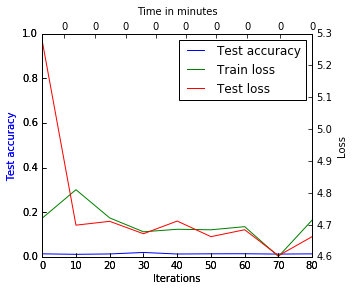

experiments/RMSProp/ done


In [32]:
pipeline(path = 'experiments/RMSProp/', optimizer='RMSProp', max_iter = 90)